In [175]:
import os
from roboflow import Roboflow
from PIL import Image
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

In [176]:
current_dir = (os.getcwd())
current_dir

'd:\\DAFFA PINJEM BUAT BACKUP\\TA GASS\\FIX\\Yolo'

In [177]:
source_dir = './Testing/'
source_multi_dir = './Multi-Object/'
target_dir = './Result/'
target_multi_dir = './Multi-Object-Result/'

In [178]:
# Initialize API for coffee bean detection
rf = Roboflow(api_key="IluK8shPQ2JbRq6f5FVM")

# Reference : https://universe.roboflow.com/coffeebean/coffeebean-5wnfh/model/1
# project = rf.workspace().project("coffeebean-5wnfh")
# model = project.version(1).model

# Reference : https://universe.roboflow.com/tirta-inovan-lgpth/coffee-det./model/2
# project = rf.workspace().project("coffee-det.")
# model = project.version(2).model

# Reference : https://universe.roboflow.com/coffe-dataset/coffee-beans-znwfe/model/2
project = rf.workspace().project("coffee-beans-znwfe")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


In [179]:
confident = 40
overlap = 30

In [180]:
def predict_images(filename):
  # infer on a local image
  print(model.predict(f"{source_dir}{filename}", confidence=confident, overlap=overlap).json())

  # visualize your prediction
  model.predict(f"{source_dir}{filename}", confidence=confident, overlap=overlap).save(f"{target_dir}{filename}")

In [181]:
def predict_image_multi(filename):
  # infer on a local image
  result = model.predict(f"{source_multi_dir}{filename}", confidence=confident, overlap=overlap).json()

  # visualize your prediction
  model.predict(f"{source_multi_dir}{filename}", confidence=confident, overlap=overlap).save(f"{target_multi_dir}{filename}")
  return result

In [183]:
# Define the class labels
class_labels = ['Dark', 'Green', 'Light', 'Medium']

# Load the pre-trained model
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(2048, 4)  # replace the last layer with a binary classifier
# resnet50.load_state_dict(torch.load('resnet50-coffee-defect.pth'))
resnet50.load_state_dict(torch.load('resnet50-coffee-roast-level.pth'))

<All keys matched successfully>

In [184]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

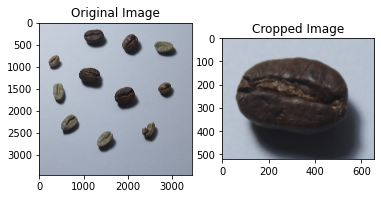

Predicted class: Medium


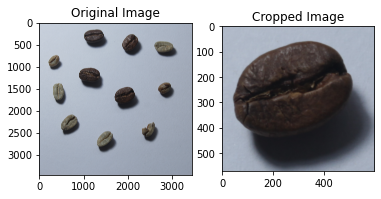

Predicted class: Medium


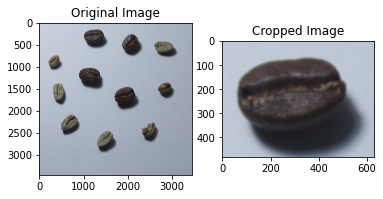

Predicted class: Medium


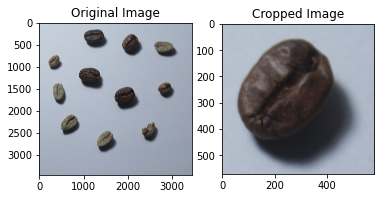

Predicted class: Medium


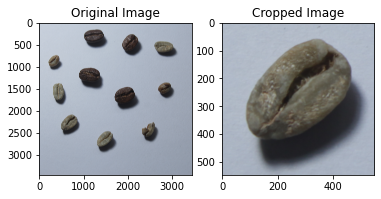

Predicted class: Medium


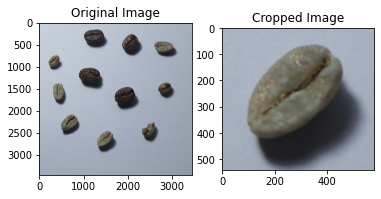

Predicted class: Medium


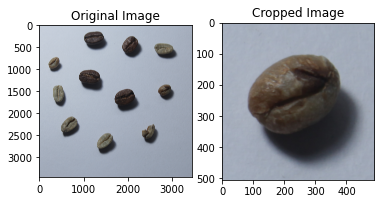

Predicted class: Medium


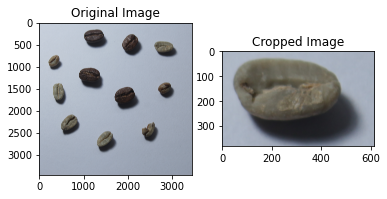

Predicted class: Medium


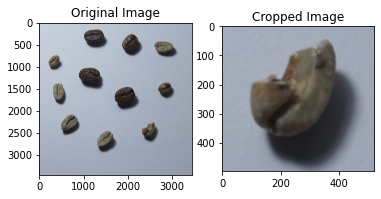

Predicted class: Medium


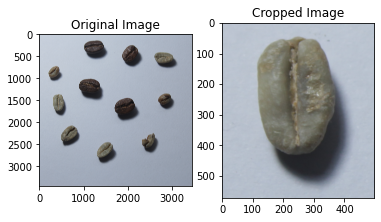

Predicted class: Medium


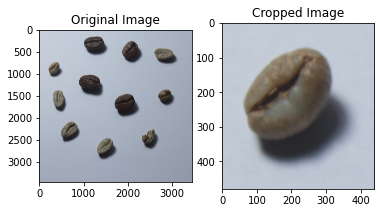

Predicted class: Medium


In [186]:
# file_image = os.listdir(source_dir)

# for img in file_image:
#     predict_images(img)

file_images = os.listdir(source_multi_dir)
result_list = []

for file_image in file_images:
    result = predict_image_multi(file_image)

    # Open the image file
    for predict in result["predictions"]:
        img = Image.open(os.path.join(source_multi_dir, file_image))

        # Set the crop region
        x, y, width, height = predict["x"], predict["y"], predict["width"], predict["height"]
        crop_region = (x-(int(width/2)), y-(int(height/2)), x+(int(width/2)), y+(int(height/2)))

        # Crop the image
        cropped_img = img.crop(crop_region)

        # Display the original and cropped images
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax2.imshow(cropped_img)
        ax2.set_title('Cropped Image')
        plt.show()

        # Apply the transforms to the image
        img_tensor = transform(cropped_img)

        # Add a batch dimension to the tensor
        img_tensor = img_tensor.unsqueeze(0)

        # Make a prediction using the model
        with torch.no_grad():
            output = resnet50(img_tensor)

        # Get the predicted class label
        _, predicted = torch.max(output.data, 1)
        predicted_label = class_labels[predicted.item()]

        # Print the predicted class label
        print('Predicted class:', predicted_label)
    result_list.append(result)

with open('result.json', 'w') as f:
    json.dump(result_list, f)